# Pycharm version is more up-to-date! 

### Check: calibrator.py -> def save_ranked_corner_crops() and def determine_corner_outliers()

In [1]:
%reset -f
import cv2
import os
import glob 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import datetime


def now_str():
    now = datetime.datetime.now()
    output = '*[{}/{} {}:{}:{}]*'.format(now.month, now.day, now.hour, now.minute, now.second)
    return output

sys.path.insert(1, r'C:\Users\hjoon\Documents\PycharmProjects\CameraCalibration')

from modules.calibrator import *
from configs import *

mpl.style.use('seaborn')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
cams = Calibrator.cams

%matplotlib notebook
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print('init')

init


# Load corners

In [2]:
# num_cams = 16
# root_path = r'D:\Pictures\2019_12_03_capture\Converted'

root_path = r'D:\Pictures\2019_08_09_AllPoseCapture\Converted'
num_cams = 8

# num_cams x {img_name : [corner points]}
corner_data = {}
num_frames = {}
img_names_set = set()
print('Loading for camera: ', end='')
for cam_idx in range(num_cams):
    print('{} '.format(cams[cam_idx]), end='')

    input_path = root_path + '\\' + cams[cam_idx] + '\\Corners\\*.txt'
    file_paths = glob.glob(input_path)

    for f_path in file_paths:
        f_name = f_path.split('\\')[-1]
        img_name = f_name.split('.')[0]
        img_names_set.add(img_name)
        corners = Parser.load_corner_txt(f_path)
        if len(corners) > 0:
            if cam_idx in corner_data:
                corner_data[cam_idx].update({img_name: corners})
            else:
                corner_data[cam_idx] = {img_name: corners}

            if cams[cam_idx] in num_frames:
                num_frames[cams[cam_idx]] += 1
            else:
                num_frames[cams[cam_idx]] = 1

print()
print('Loaded corners:', num_frames)
img_names_list = sorted(list(img_names_set))

Loading for camera: A B C D E F G H 
Loaded corners: {}


# Create neighbor indices for each corner point

In [3]:
neighbor_indices = []
for r in range(8):
    for c in range(11):
        neighbors = {}
        if r == 7:
            s = -1
        else:
            s = (r + 1) * 11 + c

        if r == 0:
            n = -1
        else:
            n = (r - 1) * 11 + c

        if c == 0:
            w = -1
        else:
            w = r * 11 + c - 1

        if c == 10:
            e = -1
        else:
            e = r * 11 + c + 1

        neighbors['n'] = n
        neighbors['s'] = s
        neighbors['e'] = e
        neighbors['w'] = w
        neighbor_indices.append(neighbors)
print('done')

done


### Define some functions

In [4]:
def __dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def __crop_square(img, center, length):
    # create mask
    height, width, _ = img.shape
    mask = np.zeros((height, width), np.uint8)

    # draw the circles on mask (set thickness to -1 to fill the circle)
    #     cv2.circle(mask, (int(center[0]), int(center[1])), int(radius), (255, 255 ,255), thickness=-1)
    length_half = int(0.5 * length)
    start_point = (center[0] - length_half + 1, center[1] - length_half + 1)
    end_point = (center[0] + length_half, center[1] + length_half)
    cv2.rectangle(mask, start_point, end_point, (255, 255, 255), thickness=-1)

    # copy that image using mask
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    # apply Threshold
    _, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    # find Contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0])

    # crop masked_data
    crop = masked_data[y:y + h, x:x + w]
    

    return crop
print('done')

done


# Find min distance to neighbors for each point.

In [5]:
# compute distance between neighbors for each point
# {'cam_idx': 'image_name' : {'min': [88], 'max': [88], 'avg': [88]}]}
neighbor_dists = {}
for cam_idx in range(num_cams):
    print()
    print('  Camera[{}] | '.format(cam_idx), end='')
    print('  ', end='')
    dist_dics = {}
    for frame_idx, img_name in enumerate(img_names_list):
        if frame_idx % 100 == 0:
            print('  {}/{}'.format(frame_idx, len(img_names_list)), end='')

        if img_name not in corner_data[cam_idx]:
            continue

        corners = corner_data[cam_idx][img_name]
        mins = []
        maxs = []
        avgs = []
        for p_idx, point in enumerate(corners):
            neigh = neighbor_indices[p_idx]

            min_dist = np.inf
            max_dist = -1
            avg_dist = 0
            num_neigh = 0
            for k, neigh_idx in neigh.items():
                if neigh_idx > -1:
                    num_neigh += 1
                    neigh_point = corners[neigh_idx]
                    dist_curr = __dist(point, neigh_point)
                    avg_dist += dist_curr
                    if dist_curr < min_dist:
                        min_dist = dist_curr
                    if dist_curr > max_dist:
                        max_dist = dist_curr

            avg_dist /= num_neigh
            mins.append(min_dist)
            maxs.append(max_dist)
            avgs.append(avg_dist)
        curr_frame = {'min': mins, 'max': maxs, 'avg': avgs}
        dist_dics[frame_idx] = curr_frame
    neighbor_dists[cam_idx] = dist_dics
print()
print('done')


  Camera[0] |   
  Camera[1] |   
  Camera[2] |   
  Camera[3] |   
  Camera[4] |   
  Camera[5] |   
  Camera[6] |   
  Camera[7] |   
done


# ChESS criteria

### circular sample mask

<IPython.core.display.Javascript object>


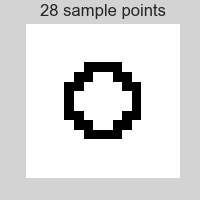

(16, 16)


In [44]:
import math
mask = np.zeros((16, 16)).astype('uint8')
cx = 8.0
cy = 8.0
r = int(mask.shape[0] * 0.25) - 0.5
mask_vu = []
mask_type = 'circle'
if mask_type == 'circle':
    for theta in np.linspace(1, int(np.pi*2 + 1), 360):
        v = int(cy + r*math.sin(theta))
        u = int(cx + r*math.cos(theta))
        if mask[v, u] == 0:
            mask[v, u] = 1
            mask_vu.append((v, u))
elif mask_type == 'square':
    sy = int(cy - r)
    sx = int(cx - r)
    ey = int(cy + r) + 1
    ex = int(cx + r) + 1
    for v in range(sy + 1, ey):
        if mask[v, ex] == 0:
            mask[v, ex] = 1
            mask_vu.append((v, ex))
        
    for u in range(ex - 1, sx, -1):
        if mask[ey, u] == 0:
            mask[ey, u] = 1
            mask_vu.append((ey, u))
            
    for v in range(ey - 1, sy, -1):
        if mask[v, sx] == 0:
            mask[v, sx] = 1
            mask_vu.append((v, sx))
    for u in range(sx + 1, ex):
        if mask[sy, u] == 0:
            mask[sy, u] = 1
            mask_vu.append((sy, u))

fig = plt.figure(figsize=(2,2))
fig.patch.set_facecolor('lightgray')
plt.title('{} sample points'.format(np.sum(mask)))
plt.imshow(mask)
# for r in np.linspace(0, 16, 16):
#     plt.plot([0, 16], [r, r], 'r-', linewidth=1)
# for c in np.linspace(0, 16, 16):
#     plt.plot([c, c], [0, 16], 'k-', linewidth=1)
plt.xticks([]), plt.yticks([])
plt.show()
print(mask.shape)


### ChESS

In [147]:
def ChESS(image, mask):
    I = np.array(image, copy=True).astype('float32')
    gb = np.zeros((I.shape[0], I.shape[1], 2))
    image = np.dstack((I, gb))
    
    score = 0
    sample_indices = range(int(0.25*len(mask)))
    half = int(len(sample_indices)*2)
    quater = int(len(sample_indices))
    for idx0 in sample_indices:
        idx1 = idx0 + half
        ortho_idx0 = idx0 + quater
        ortho_idx1 = ortho_idx0 + half
        
        image[mask[idx0]] = [0, 0, 255]
        image[mask[idx1]] = [0, 255, 0]
        image[mask[ortho_idx0]] = [0, 255, 255]
        image[mask[ortho_idx1]] = [255, 255, 0]
        
        # sum response (SR)
        score += np.abs((I[mask[idx0]]+I[mask[idx1]]) - (I[mask[ortho_idx0]]+I[mask[ortho_idx1]]))
        
        # diff response (DR)
        score -= np.abs(I[mask[idx0]]-I[mask[idx1]]) + np.abs(I[mask[ortho_idx0]]-I[mask[ortho_idx1]])
        
#     score /= 255.0
    return image, score

# Crop squares

In [181]:
%matplotlib inline
output_path = root_path + '\\CroppedCorners'
if not os.path.exists(output_path):
    os.makedirs(output_path)
print('Saving to:', output_path)
h, w = Configs.image_shape
dpi = 300
scale = 1.0
sz = 5

x = np.linspace(0, 16, 17)
y = np.linspace(0, 16, 17)

for cam_idx in range(num_cams):
    print('\n  Camera[{}]\n  '.format(cam_idx), end='')
    for frame_idx, img_name in enumerate(img_names_list):
        if frame_idx % 100 == 0:
            print('  {}/{}'.format(frame_idx, len(img_names_list)), end='')
        if img_name not in corner_data[cam_idx]:
            continue

        corners = corner_data[cam_idx][img_name]

        save_folder = root_path + '\\CornerCrop\\' + cams[cam_idx] + '\\' + img_name
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for p_idx, corner in enumerate(corners):
            save_path = save_folder + '\\' + str(p_idx) + '.jpg'

            img_dir = root_path + '\\' + cams[cam_idx] + '\\' + img_name + '.pgm'
            img_w = int(w * scale)
            img_h = int(h * scale)
            
            img = cv2.imread(img_dir)
            img = cv2.resize(img, (img_w, img_h))

            xc = int(scale * corner[0])
            yc = int(scale * corner[1])
            length = 16

            crop = __crop_square(img, (xc, yc), length)

            crop = np.array(crop).astype('uint8')[:, :, 0]

#             crop = cv2.equalizeHist(crop) 
            blur = cv2.GaussianBlur(crop, (3,3), 0)

            blur_masked, score = ChESS(blur, mask_vu)
            if score < 500:
                fig = plt.figure(figsize=(500/dpi, 500/dpi), dpi=dpi)
                fig.patch.set_facecolor('lightgray')

                plt.xticks([]), plt.yticks([])
                img_title = '{}_{}_{}_{}'.format(cam_idx, img_name, p_idx, score)
                fig.suptitle(img_title, fontsize=10)
                plt.grid(False)

                # red lines
                plt.scatter(7.5, 7.5, s=sz, c='r')
                plt.scatter([7.5]*len(y), y, s=sz*0.2, c='r')
                plt.scatter(x, [7.5]*len(x), s=sz*0.2, c='r')
                plt.imshow(crop)
#                 plt.show()
                plt.rcParams['savefig.facecolor'] = 'lightgray'
                plt.savefig(output_path + '\\' + img_title + '.jpg', dpi=dpi)
                plt.close('all')
            del img, crop, blur, blur_masked

Saving to: D:\Pictures\2019_08_09_AllPoseCapture\Converted\CroppedCorners

  Camera[0]
    0/940  100/940  200/940  300/940  400/940  500/940

KeyboardInterrupt: 

# Load cropped images, rank them. Determine outliers

In [4]:
import shutil
print(now_str())
root_path = r'D:\Pictures\2019_08_09_AllPoseCapture\Converted'
input_path = root_path + '\\CroppedCorners'
output_path = input_path + '\\Ranked'
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
crop_paths = glob.glob(input_path + '\\*.jpg')

crop_data = {}
scores = {}
for c_idx, crop_path in enumerate(crop_paths):
    name = crop_path.split('\\')[-1].split('.jpg')[0]
    names = name.split('_')
    cam_idx = int(names[0])
    img_name = names[1]
    p_idx = names[2]
    score = names[3]
    scores[c_idx] = score
    crop_data[c_idx] = {'cam_idx': cam_idx, 'img_name': img_name, 'p_idx': p_idx, 'score': score, 'path': crop_path, 'file_name': name}

print('{} cropped corners ranked'.format(len(scores.keys())))
sorted_scores = sorted(scores.items(), key=lambda kv: kv[1])

rank = 0
for c_idx, score in sorted_scores:
    if c_idx % 100 == 0:
        print(' [{}/{}]'.format(c_idx, len(sorted_scores)))
    c_data = crop_data[c_idx]
    
    # sanity check
    if c_data['score'] != score:
        print('[ERROR] crop score mismatch!')
        
    
    # rename cropped image
    src_dir = c_data['path']
    dir_extract = src_dir.split('\\')[0:-1]
    dst_dir= '\\'.join(dir_extract) + '\\Ranked\\' + str(rank) + '_' + c_data['file_name'] + '.jpg'
    shutil.copy(src_dir,dst_dir)
    rank += 1


*[12/4 21:16:50]*
37 cropped corners ranked
 [0/37]


# Determine outliers from the saved crop images

In [ ]:
score_thres = 1000

input_corner_path = r'D:\Utah\2019_08_09_AllPoseCapture\Converted\\'
input_score_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCropRanked_\\'

# get all list of subset of cropped corners
cropped_list = glob.glob(input_score_path + '*.jpg')
cropped_dic = {}  # key=cam_idx : [img_name]
for cropped in cropped_list:
    crop_name = cropped.split('\\')[-1].split('.')[0]
    v = crop_name.split('_')
    cam_idx = int(v[1])
    img_name = v[2]
    score = int(v[-1])
    if score < score_thres:
        # outlier
        if cam_idx in cropped_dic:
            cropped_dic[cam_idx].append(img_name)
        else:
            cropped_dic[cam_idx] = [img_name]

output_root_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCrop\\'

for cam_idx in range(8):
    output_path = output_root_path + 'outlier_' + str(cam_idx) + '.txt'
    
    # set all images as non-outlier first.
    img_2_outlier = {}
    corner_path = input_corner_path + str(cam_idx) + '\Corners\*.txt'
    corners_list = glob.glob(corner_path)
    for corner in corners_list:
        with open(corner, 'r') as f:
            line = f.readline()
            if line[0] == 't' or line[0] == 'T':
                img_name = corner.split('\\')[-1].split('.')[0]
                img_2_outlier[img_name] = 0
            f.close()
        
    # mark outliers
    outlier_list = cropped_dic[cam_idx]
    for outlier_img_name in outlier_list:
        img_2_outlier[outlier_img_name] = 1
    
    # save to txt
    num_outliers = 0
    with open(output_path, 'w+') as f:
        f.write(str(cam_idx) + ' ' + str(len(img_2_outlier.keys()))+ '\n')
        for k, v in img_2_outlier.items():
            f.write(str(k) + ' ' + str(v) + '\n')
            if int(v) == 1:
                num_outliers += 1
        f.close()
    print('Camera[{}]: {}/{} outliers'.format(cam_idx, num_outliers, len(img_2_outlier.keys())))
        
print('done')

score_thres = 1000

input_corner_path = r'D:\Utah\2019_08_09_AllPoseCapture\Converted\\'
input_score_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCropRanked_\\'

# get all list of subset of cropped corners
cropped_list = glob.glob(input_score_path + '*.jpg')
cropped_dic = {}  # key=cam_idx : [img_name]
for cropped in cropped_list:
    crop_name = cropped.split('\\')[-1].split('.')[0]
    v = crop_name.split('_')
    cam_idx = int(v[1])
    img_name = v[2]
    score = int(v[-1])
    if score < score_thres:
        # outlier
        if cam_idx in cropped_dic:
            cropped_dic[cam_idx].append(img_name)
        else:
            cropped_dic[cam_idx] = [img_name]

output_root_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCrop\\'

for cam_idx in range(8):
    output_path = output_root_path + 'outlier_' + str(cam_idx) + '.txt'
    
    # set all images as non-outlier first.
    img_2_outlier = {}
    corner_path = input_corner_path + str(cam_idx) + '\Corners\*.txt'
    corners_list = glob.glob(corner_path)
    for corner in corners_list:
        with open(corner, 'r') as f:
            line = f.readline()
            if line[0] == 't' or line[0] == 'T':
                img_name = corner.split('\\')[-1].split('.')[0]
                img_2_outlier[img_name] = 0
            f.close()
        
    # mark outliers
    outlier_list = cropped_dic[cam_idx]
    for outlier_img_name in outlier_list:
        img_2_outlier[outlier_img_name] = 1
    
    # save to txt
    num_outliers = 0
    with open(output_path, 'w+') as f:
        f.write(str(cam_idx) + ' ' + str(len(img_2_outlier.keys()))+ '\n')
        for k, v in img_2_outlier.items():
            f.write(str(k) + ' ' + str(v) + '\n')
            if int(v) == 1:
                num_outliers += 1
        f.close()
    print('Camera[{}]: {}/{} outliers'.format(cam_idx, num_outliers, len(img_2_outlier.keys())))
        
print('done')

In [ ]:
score_thres = 1000

input_corner_path = r'D:\Utah\2019_08_09_AllPoseCapture\Converted\\'
input_score_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCropRanked_\\'

# get all list of subset of cropped corners
cropped_list = glob.glob(input_score_path + '*.jpg')
cropped_dic = {}  # key=cam_idx : [img_name]
for cropped in cropped_list:
    crop_name = cropped.split('\\')[-1].split('.')[0]
    v = crop_name.split('_')
    cam_idx = int(v[1])
    img_name = v[2]
    score = int(v[-1])
    if score < score_thres:
        # outlier
        if cam_idx in cropped_dic:
            cropped_dic[cam_idx].append(img_name)
        else:
            cropped_dic[cam_idx] = [img_name]

output_root_path = r'D:\Utah\2019_08_09_AllPoseCapture\CornerCrop\\'

for cam_idx in range(8):
    output_path = output_root_path + 'outlier_' + str(cam_idx) + '.txt'
    
    # set all images as non-outlier first.
    img_2_outlier = {}
    corner_path = input_corner_path + str(cam_idx) + '\Corners\*.txt'
    corners_list = glob.glob(corner_path)
    for corner in corners_list:
        with open(corner, 'r') as f:
            line = f.readline()
            if line[0] == 't' or line[0] == 'T':
                img_name = corner.split('\\')[-1].split('.')[0]
                img_2_outlier[img_name] = 0
            f.close()
        
    # mark outliers
    outlier_list = cropped_dic[cam_idx]
    for outlier_img_name in outlier_list:
        img_2_outlier[outlier_img_name] = 1
    
    # save to txt
    num_outliers = 0
    with open(output_path, 'w+') as f:
        f.write(str(cam_idx) + ' ' + str(len(img_2_outlier.keys()))+ '\n')
        for k, v in img_2_outlier.items():
            f.write(str(k) + ' ' + str(v) + '\n')
            if int(v) == 1:
                num_outliers += 1
        f.close()
    print('Camera[{}]: {}/{} outliers'.format(cam_idx, num_outliers, len(img_2_outlier.keys())))
        
print('done')